*Brandon Lee, 2024*
This program models a market of mutually exclusive buyers and sellers where:
- their entrances into the market are Poisson arrival processes,
- they leave the market only after engaging in a transaction
- their behavior follows expected utility theory, and
- the utility of the product is nonrandom

Model specification options:
- linear EU / risk-averse EU / prospect utility theory
- rational / real probability weighting
- exponential / hyperbolic time discounting


In [1]:
import numpy as np
from typing import Callable
import clearing_price
from matplotlib import pyplot as plt
import dynarray

In [7]:
class ArrivalMarket:
    def __init__(
            self,
            expected_buyer_arrivals: float,
            expected_seller_arrivals: float,
            generate_buyer: Callable[[], float], # generates a buyer with some monetary valuation of the product
            generate_seller: Callable[[], float]
        ):
        """
        :param expected_buyer_arrivals: expected number of buyers arriving in one time unit
        :param expected_seller_arrivals: expected number of sellers arriving in one time unit
        :param generate_buyer: function to randomly generate a buyer Agent
        :param generate_seller: function to randomly generate a seller Agent
        """
        self.expected_buyer_arrivals = expected_buyer_arrivals
        self.expected_seller_arrivals = expected_seller_arrivals
        self.generate_buyer = generate_buyer
        self.generate_seller = generate_seller
        
    def run_simulation(self, time_horizon: float):
        """
        :param time_horizon: how many time units the simulation should last
        """
        buyer_product_values = dynarray.DynamicArray() # list of buyer product_value ordered by buyer offering most to least
        seller_product_values = dynarray.DynamicArray() # list seller product_value ordered by accepting least to most

        current_time: float = 0
        next_buyer_arrival_time: float = np.random.exponential(self.expected_buyer_arrivals)
        next_seller_arrival_time: float = np.random.exponential(self.expected_seller_arrivals)

        results_log: list[list[float]] = list() # list of triples (time, number of buyers in market, number of sellers in market)
        results_log.append([current_time, len(buyer_product_values), len(seller_product_values)])

        while True:
            # insert buyer or seller into pool when they arrive
            current_time = np.min([time_horizon, next_buyer_arrival_time, next_seller_arrival_time])
            if current_time == next_buyer_arrival_time:
                buyer_product_values.append(self.generate_buyer())
                next_buyer_arrival_time = current_time + np.random.exponential(1/self.expected_buyer_arrivals)
            elif current_time == next_seller_arrival_time:
                seller_product_values.append(self.generate_seller())
                next_seller_arrival_time = current_time + np.random.exponential(1/self.expected_seller_arrivals)
            else:
                break

            # make all possible deals in current market at median clearing_price, removing successful agents
            price = clearing_price.find_median_clearing_price(buyer_product_values, seller_product_values)
            if price:
                buyer_product_values = dynarray.DynamicArray(buyer_product_values[buyer_product_values < price])
                seller_product_values = dynarray.DynamicArray(seller_product_values[seller_product_values > price])

            results_log.append([current_time, len(buyer_product_values), len(seller_product_values)])

        results_log = np.array(results_log)
        plt.plot(results_log[:,0], results_log[:,1], label="Number of Buyers")
        plt.plot(results_log[:,0], results_log[:,2], label="Number of sellers")
        plt.xlabel("Time")
        plt.legend()
        plt.show()

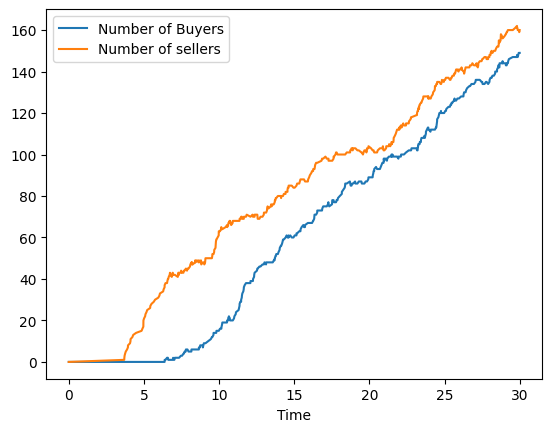

In [16]:
my_market = ArrivalMarket(
    expected_buyer_arrivals = 10,
    expected_seller_arrivals = 10,
    generate_buyer = lambda : np.random.normal(1,1),
    generate_seller = lambda : np.random.normal(2,0.5)
)
my_market.run_simulation(time_horizon=30)